(tensorflow 사용법)
https://www.tensorflow.org/tutorials/images/segmentation?hl=ko

https://wiserloner.tistory.com/1050 

In [1]:
import tensorflow as tf

In [2]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

__data 정규화 : 0~1 사이로 숫자로 만들기__

In [4]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0       #cast:소수점 떼기
  input_mask -= 1
  return input_image, input_mask


__def train data__

In [11]:
#이미지 128 크기로 다시 늘리기
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    

#이미지 반대로 뒤집기   

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
    

#이미지 정규화

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

__def test data __

In [12]:

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

__train data 나누기__

In [16]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000    #데이터셋 객체의 셔플 함수에 사용되는 것
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

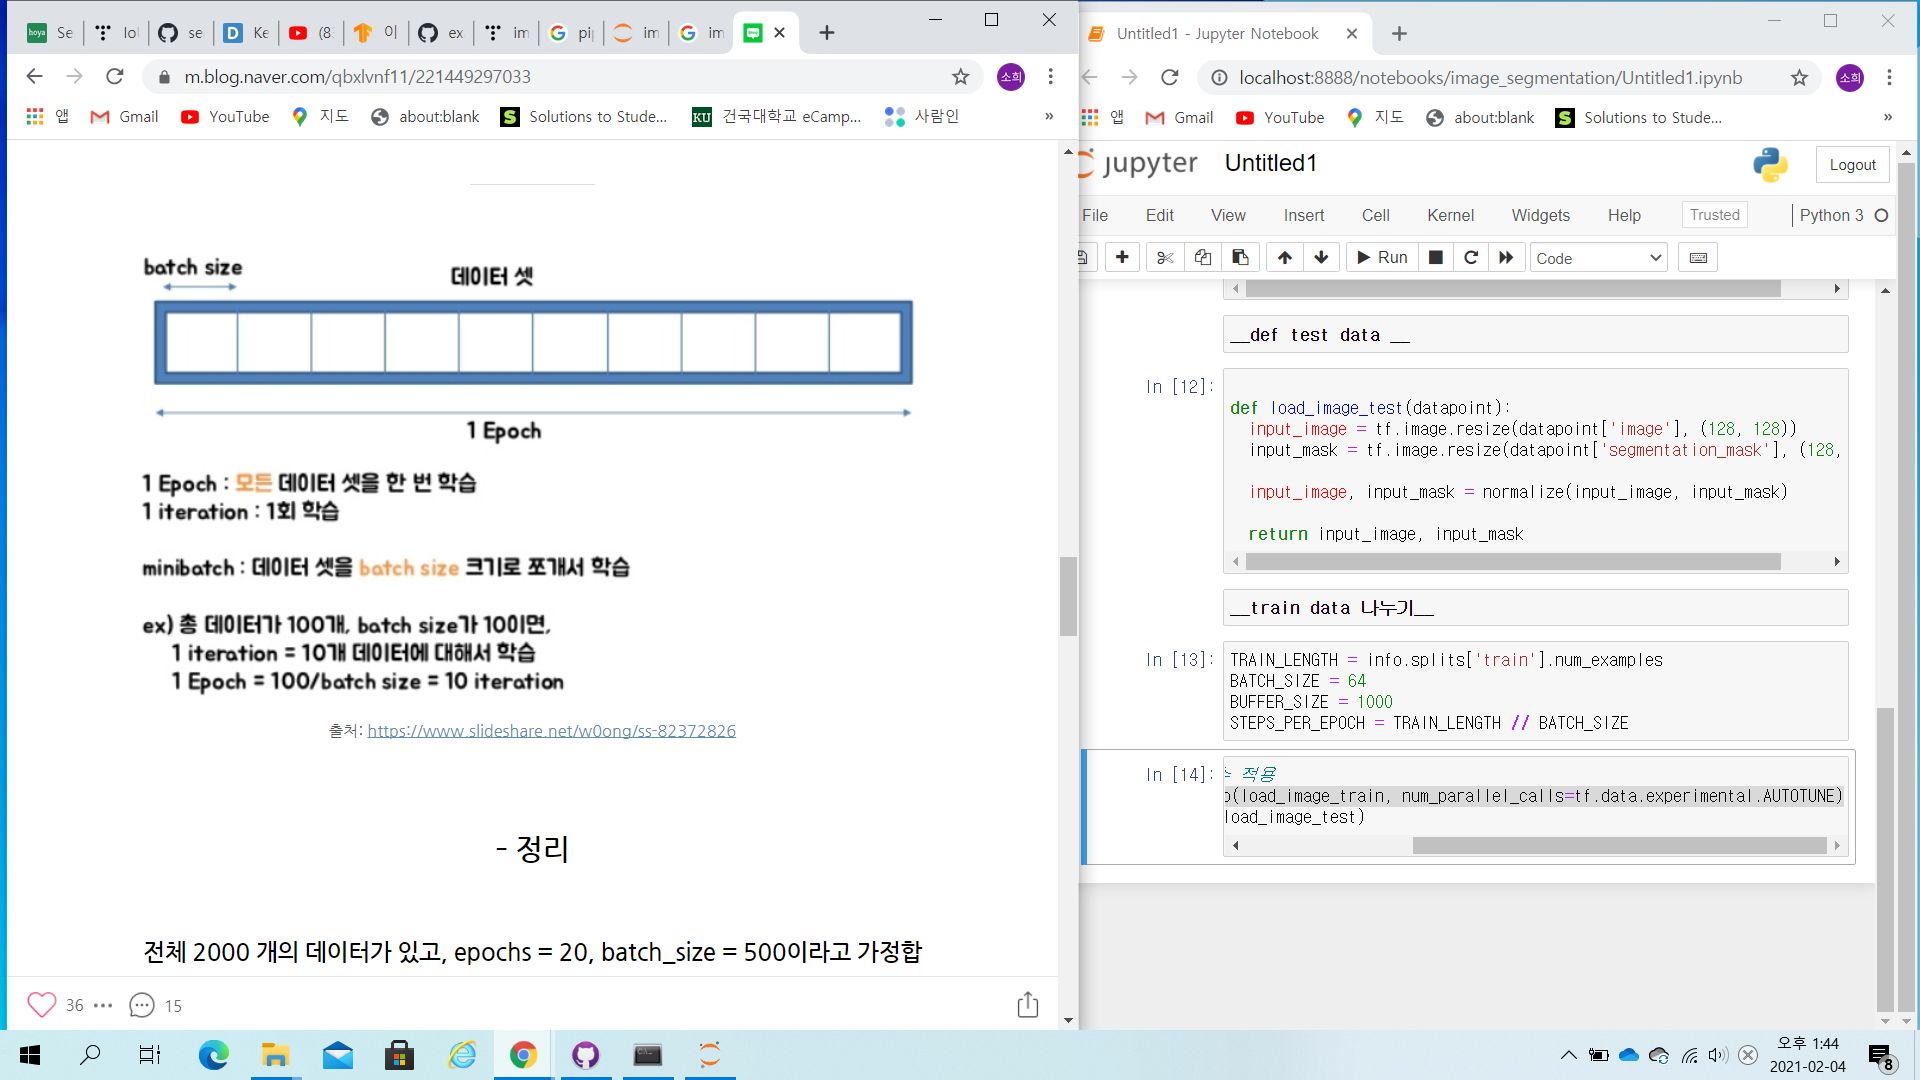

In [14]:
# map 함수 : 사용자 지정함수 적용
#콜백함수를 병렬처리한다(데이터 셋의 방대한 원소를 병렬적으로 동시에 처리)
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [15]:
#데이터들을 변수 메모리에 로드
#cache() : 해당 데이터셋이 반복되는 상황에서 캐싱한다(빨리 불러올 수 있는 구간에 저장하겠다)는 뜻

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

__data 확인__

In [17]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):     #map plot 이용해서  이미지 출력
    plt.subplot(1, len(display_list), i+1)   #subplot[ plt.subplot(nrow,ncol,pos{어디에 그래프 그릴지})]은 여러개의 그래프를 그릴때 이용
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
      # array_to_img : 이미지 형태가 아닌 데이터셋을 이미지 형태로 바꾸기
    plt.axis('off')
  plt.show()

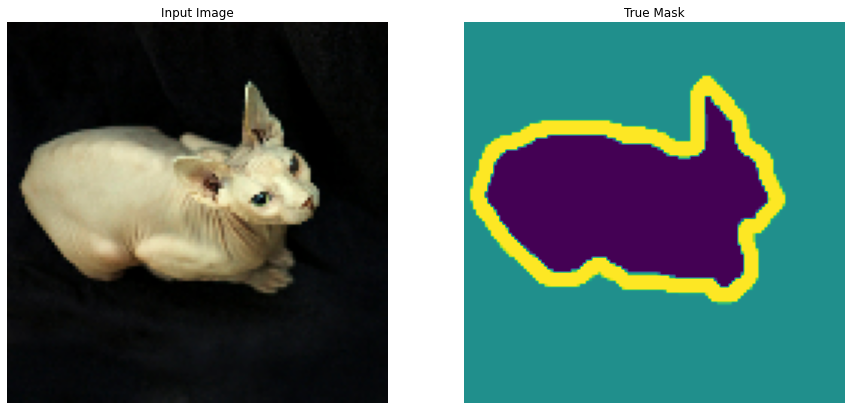

In [18]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

__channel 3개로 분류하기(image, mask, 배경)__

In [19]:
OUTPUT_CHANNELS = 3

In [20]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

#이 층들의 활성화를 이용합시다
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# 특징추출 모델을 만듭시다
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9412608/9406464 [==============================] - 5s 0us/step
